In [1]:
import math
import scipy as sp
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from Additional_functions import dcplot, Imp, Opener, cancel_borders

Import and define the SIFT for both back and front side of the stick

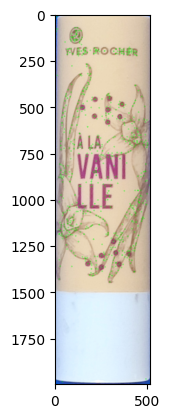

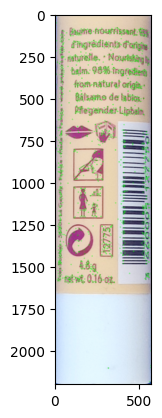

In [3]:
tubf, TUBF, filtubf, FILTUBF = Imp(("Foto CV Coesia project/Tquery_front.jpg"))
tubb, TUBB, filtubb, FILTUBB = Imp(("Foto CV Coesia project/Tquery_back.jpg"))



#series of feature computed offline and valid for each iteration
sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 100
kp_query = sift.detect(TUBF)
kp_query, des_query = sift.compute(TUBF, kp_query)

sift2 = cv2.xfeatures2d.SIFT_create()
back_query = sift2.detect(TUBB)
back_query, backdes_query = sift2.compute(TUBB, back_query)

img_visualization = cv2.drawKeypoints(TUBF,kp_query, outImage = True, color = (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
plt.imshow(img_visualization)
plt.show()

img_visualization = cv2.drawKeypoints(TUBB,back_query, outImage = True, color = (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
plt.imshow(img_visualization)
plt.show()

Now start finding those features on a new image. We want to discover the angle the stick must be turned in order to get the logo straight visible. We look for the front correspondences and then, if those weren't found we start looking for the back one. Once we got the match, from the homography got we compute the rotation. The homography finds the plane correspondent to one of the four side. In such a way we are approximating the cylindrical object into a parallelepipedo

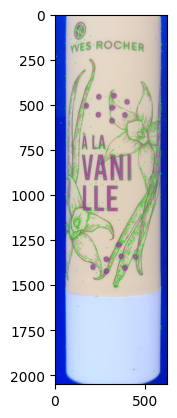

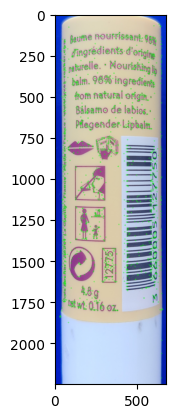

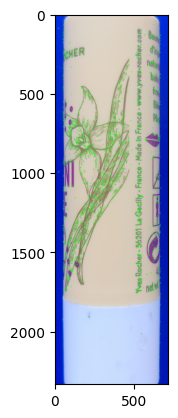

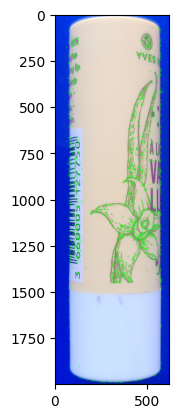

In [4]:
sift = []
query = []
FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 100
des_query = []

front, FRONT, filfront, FILFRONT = Imp("Foto CV Coesia project/Stick/Query_front.jpg")
back,BACK, filback, FILBACK = Imp("Foto CV Coesia project/Stick/Query_back.jpg")
side1, SIDE1, filside1, FILSIDE1 = Imp("Foto CV Coesia project/Stick/query_side_ccw.jpg")
side2, SIDE2, filside2, FILSIDE2 = Imp("Foto CV Coesia project/Stick/query_side_cw.jpg")

images = [FILFRONT, FILBACK, FILSIDE1, FILSIDE2]
gray_images = [front, back, side1, side2]

for i in range(0, 4, 1):
    siftis = cv2.xfeatures2d.SIFT_create()
    sift.append(siftis)
    kp_query = siftis.detect(images[i])
    kp_query, desimg_query = siftis.compute(images[i], kp_query)
    query.append(kp_query)
    des_query.append(desimg_query)
    img_visualization = cv2.drawKeypoints(images[i],kp_query, outImage = True, color = (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    plt.imshow(img_visualization)
    plt.show()
    

Now start to look for one of this sides. First of all we print out the number of feature. In this way we can break the for when we see that ther's a number of match close to the total of one side: in that way we could save some computation effort

In [5]:
print(np.size(query[0]))
print(np.size(query[1]))
print(np.size(query[2]))
print(np.size(query[3]))

1884
2816
2875
2230


And now the function where we compute the correspondence between one of the four face: we don't simply choose the side with the most correspondences but the side with the highest percentage of correspondences; in that way we don't penalize the side with less correspondences and then compute from it the orientation

[0.2346072186836518, 0, 0, 0]
Frontal correspondences are: 442
442
[0.2346072186836518, 0.10475852272727272, 0, 0]
295
[0.2346072186836518, 0.10475852272727272, 0.16521739130434782, 0]
475
[0.2346072186836518, 0.10475852272727272, 0.16521739130434782, 0.09147982062780269]
204


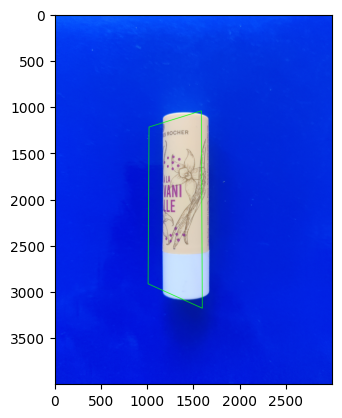

In [6]:
stick, STICK, filstick, FILSTICK = Imp("Foto CV Coesia project/Stick/S9.jpg")

kp_train = []
des_train = []
matches = []
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
percentages = [0,0,0,0]
for i in range (0, 4, 1):
    train = sift[i].detect(FILSTICK)
    train, d_train = sift[i].compute(FILSTICK, train)
    kp_train.append(train)
    des_train.append(d_train)
    match = flann.knnMatch(des_query[i], des_train[i], k = 2)
    matches.append(match)
    good = []
    
    for m,n in matches[i]:
        if m.distance < 0.8*n.distance:
            good.append(m)

    percentages[i] = len(good)/np.size(query[i])
    print(percentages)
    if i == 0:
        good_best = good
        index = 0
        print("Frontal correspondences are:", len(good))
        
    elif i > 0:
        if percentages[i] == np.max(percentages):
            good_best = good
            print("Now the side with most correspondences is the", i)
            index = i

    if len(good_best) >= 0.75*len(query[i]):
        break
    print(len(good))

h, w = np.shape(gray_images[index])
#We find the homography with respect to the side with most correspondences -> good_best
if len(good_best) > MIN_MATCH_COUNT:
    ngood = []
    for m,n in matches[index]:
        if m.distance < 0.8*n.distance:
            ngood.append(m)
    src_pts = np.float32([ query[index][m.queryIdx].pt for m in ngood ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[index][m.trainIdx].pt for m in ngood ]).reshape(-1,1,2)
    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 24.0)
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)

    PIC = cv2.polylines(FILSTICK, [np.int32(dst)], True, (0,255, 0), 5, cv2.LINE_AA)

plt.imshow(PIC)
plt.show()


Despite the lateral side gives more correspondences, the percentage of feature is higher for the frontal side, and in fact altough the image is oriented between the frontal and lateral it looks closer to the frontal side

In [7]:
print(M1)
rotation_angle_rad = np.arctan2(M1[1, 0], M1[0, 0])
rotation_angle_deg = np.int32(np.degrees(rotation_angle_rad))
print(rotation_angle_deg)

[[ 3.96616129e-01 -1.90992006e-02  1.01420761e+03]
 [-6.19358755e-01  7.85263501e-01  1.22105896e+03]
 [-3.24126655e-04 -1.44889815e-05  1.00000000e+00]]
-57


Now let's check the two cases of integrity: the one where ther's not the white part and the one when there's only the white part. Given that the discriminance to establish the presence of defects is the present of white

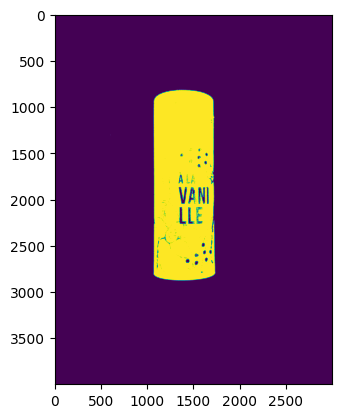

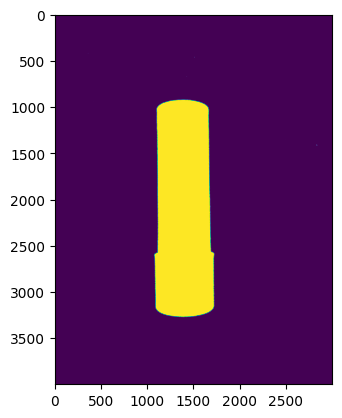

In [8]:
#Import the image where there are defects
d1, D1, fild1, FILD1 = Imp("Foto CV Coesia project/Stick/S11.jpg")
w1, W1, filw1, FILW1 = Imp("Foto CV Coesia project/Stick/S20.jpg")

#let's try a high and binary threshold in such a way to isolate the brighter parts
#see how perform with both images
twhite = 180
thresh = cv2.threshold(d1, twhite,  255, cv2.THRESH_OTSU)[1]
thresh2 = cv2.threshold(w1, twhite, 255, cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

plt.imshow(thresh2)
plt.show()




But most of all we are interested in a binarization that is able to split the white parts wrt to the yellow "body" of the stick to recognize the integer products. Then we crop the image with the corrspondence found previously and see if the lower part is mostly blue or white 

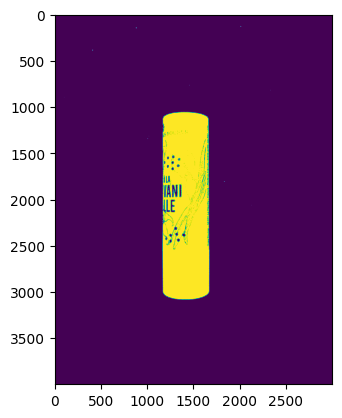

[[1014.2076 1221.059 ]
 [1004.9069 2916.6533]
 [1589.3849 3180.4421]
 [1579.3005 1046.8749]]


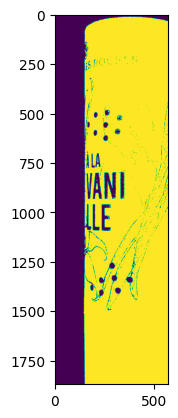

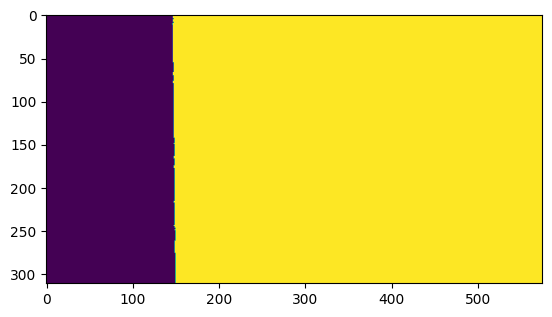

In [17]:
thresh3 = cv2.threshold(filstick,0, 255, cv2.THRESH_OTSU)[1]

plt.imshow(thresh3)
plt.show()
dst = dst.reshape(4,2)
print(dst)
dstint = np.int32(dst)
stick_thresh = thresh3[dstint[3,1]:dstint[1,1], dstint[0,0]:dstint[2,0]]
plt.imshow(stick_thresh)
plt.show()
h_stick, w_stick = np.shape(stick_thresh)
lower_part_coefficient = 6
lower_part = stick_thresh[-np.int32(h_stick/lower_part_coefficient):,:]

plt.imshow(lower_part)
plt.show()

check_white = np.sum(lower_part == 255)
if check_white <= 10000:
    ("there's not the white part, product defective")